In [371]:
import json
from yellowbrick.model_selection import ValidationCurve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from copy import deepcopy
# Data manipulation libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold,StratifiedKFold,RepeatedStratifiedKFold,GridSearchCV
# Model evaluaion libraries
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, f1_score, make_scorer

# Classiication Models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier,plot_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from navec import Navec
from sklearn.tree import DecisionTreeClassifier

# Remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

RANDOM_STATE = 42

In [6]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [7]:
def get_df(razmetka: pd.Series):
    data = pd.DataFrame(data = {'слова' : razmetka.apply(lambda x: x.keys()).explode(0).values,
                    'метки' : razmetka.apply(lambda x: x.values()).explode().values})
    data = data[data.метки != '-'][data.метки != '1']
    return data

In [8]:
def prepr(data : pd.DataFrame):
    data.метки = data.метки.apply(lambda x: 'бренд' if x in ['бред'] else x)
    data.метки = data.метки.apply(lambda x: 'наз' if x in ['назн'] else x)
    data.метки = data.метки.apply(lambda x: 'раз' if x in ['размер', 'разм'] else x)
    data.метки = data.метки.apply(lambda x: 'тов' if x in ['товар'] else x)
    data.метки = data.метки.apply(lambda x: 'мат' if x in ['материал'] else x)
    data.метки = data.метки.apply(lambda x: 'мод' if x in ['модель'] else x)

In [9]:
def get_features(X):
    
    for i in range(len(X.iloc[0, 0])):
        X[f'feat_{i+1}'] = X.Vec.apply(lambda x: x[i])
    X = X.drop('Vec', axis = 1)
    return X

In [10]:
data = pd.read_json('data/supl_biz_157k.json')
preprocessed = pd.read_json('razmetka/01_05.json')
dataset = preprocessed[preprocessed.Razme4.notna()].Razme4
dataset = get_df(dataset)
prepr(dataset)
dataset = dataset[dataset.метки != 'цвет']
dataset['Vec'] = dataset.слова.apply(lambda x: navec.get(x))
dataset = dataset[dataset.Vec.notna()]
encoder = LabelEncoder()
y = encoder.fit_transform(dataset.метки)
X = dataset[['Vec']]
X = get_features(X)

C:\Users\kustinov\AppData\Local\Temp\ipykernel_10308\604568403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f'feat_{i+1}'] = X.Vec.apply(lambda x: x[i])
C:\Users\kustinov\AppData\Local\Temp\ipykernel_10308\604568403.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'feat_{i+1}'] = X.Vec.apply(lambda x: x[i])
C:\Users\kustinov\AppData\Local\Temp\ipykernel_10308\604568403.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

In [11]:
assert X.values.shape[0]  == y.ravel().shape[0]

In [12]:
class Splitter:
    def __init__(self, kfold = True, n_repeats = None, n_splits = 5, shuffle = True):
        self.kfold = kfold
        self.n_repeats = n_repeats
        self.n_splits = n_splits
        self.shuffle = shuffle
        
    def split_data(self, X, y):
        if self.n_repeats:
            kf = RepeatedStratifiedKFold(n_repeats = self.n_repeats, n_splits = self.n_splits, shuffle = self.shuffle)
        
        else:
            kf = StratifiedKFold(n_splits = self.n_splits, shuffle = self.shuffle)
        
        for train_idx, val_idx in kf.split(X, y):
            X_train, X_val = X[train_idx, :], X[val_idx, :]
            y_train, y_val = y[train_idx], y[val_idx]
            yield X_train, X_val, y_train, y_val
    

In [13]:
class models_summary():
    def __init__(self, classifiers =  {'SVC':SVC(), 
                            'RF':RandomForestClassifier(), 
                            'CatBoost':CatBoostClassifier(silent=True), 
                            'LogReg':LogisticRegression()}):
        self.classifiers = classifiers
        self.cv_results = dict(zip(list(self.classifiers.keys()), [None] * len(self.classifiers))) 
         
        self.holdout_results = dict(zip(list(self.classifiers.keys()), [None] * len(self.classifiers)))
                
        
    def fit(self, X_ : np.array, y_ : np.array, holdout_size = 0.2, random_state = None, n_splits = 5):
        self.n_splits = n_splits
        self.holdout_size = holdout_size
        self.X, self.X_holdout, self.y, self.y_holdout = train_test_split(X_, y_,\
                                                                          test_size=self.holdout_size, stratify = y_)

        for classifier_name in list(self.classifiers.keys()):
            splitter = Splitter(n_splits=self.n_splits)
            model = self.classifiers[classifier_name]
            self.cv_results[classifier_name] = []
            for X_train, X_val, y_train, y_val in splitter.split_data(self.X, self.y):
                model.fit(X_train, y_train)
                score = model.score(X_val, y_val)
                self.cv_results[classifier_name].append(score)

            holdout_score = model.score(self.X_holdout, self.y_holdout)
            self.holdout_results[classifier_name] = holdout_score

            print(f'{classifier_name} fitted,\nHoldout Result = {holdout_score}')
        return pd.DataFrame({'model_name' : list(self.classifiers.keys()),
                            'holdout_score' : list(self.holdout_results.values())})

        
        
        
        

In [14]:
summary = models_summary()
df = summary.fit(X.values, y, n_splits = 4)

SVC fitted,
Holdout Result = 0.7717391304347826
RF fitted,
Holdout Result = 0.7717391304347826
CatBoost fitted,
Holdout Result = 0.7065217391304348
LogReg fitted,
Holdout Result = 0.75


## Split Data

In [15]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size = 0.2)

## Grids

In [58]:
RF_grid = { 
    'n_estimators': [200, 300],
    'max_features': ['sqrt'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CatBoost_grid = {'depth'         : [4,5,6,7,8],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70]
                 }

logreg_grid = {'penalty' : ['l2', 'l1'],
               'C' : [0.5, 0.8, 1]
}

DecisionTree_grid = {'max_depth' : [2,4,6,8,10,12]}

## Decision Tree 

In [16]:
clf = DecisionTreeClassifier()

In [72]:
f1_weighted = make_scorer(f1_score, average = 'weighted')

In [20]:
grid = {
    'max_depth' : range(2, 11, 2),
    'min_samples_split' : range(2,7,2)
}
gridsearch = GridSearchCV(estimator = clf, param_grid = grid, cv = 5,\
                          scoring = f1_weighted)

In [21]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 11, 2),
                         'min_samples_split': range(2, 7, 2)},
             scoring=make_scorer(f1_score, average=weighted))

In [26]:
best_tree = gridsearch.best_estimator_
best_tree.fit(X_train, y_train)
pred = best_tree.predict(X_holdout)
print(f1_score(pred, y_holdout, average = 'weighted'),'\n', classification_report(pred, y_holdout))

0.7622498843336595 
               precision    recall  f1-score   support

           3       0.90      0.82      0.86        11
           4       0.20      0.33      0.25         3
           5       0.58      0.58      0.58        12
           6       0.86      0.67      0.75         9
           7       0.57      0.72      0.63        18
           8       0.94      0.85      0.89        39

    accuracy                           0.75        92
   macro avg       0.67      0.66      0.66        92
weighted avg       0.78      0.75      0.76        92



## CatBoost Classifier

# GridSearch

In [60]:
estimators = {RandomForestClassifier() : [RF_grid, 'RF'], 
#              CatBoostClassifier() : CatBoost_grid, 
              LogisticRegression() : [logreg_grid, 'LogReg'],
            DecisionTreeClassifier() : [DecisionTree_grid, 'Tree']}


In [109]:
names = ['RF', 'LogReg', 'Tree']

## KFold

In [70]:
cv = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

In [118]:
for estimator, grid in list(estimators.items()):
    gridsearch = GridSearchCV(estimator=estimator, param_grid=grid[:-1], scoring=f1_weighted, cv=cv)
    gridsearch.fit(X_train, y_train)
    print(f'{grid[-1]} Fitted\nBest Score:{gridsearch.best_score_}')

    
    pd.DataFrame(gridsearch.cv_results_).to_json(f'cv_results/{grid[-1]}_results.json')
    print(f'File cv_results/{grid[-1]}_results.json written!')
    pd.DataFrame(gridsearch.best_params_, index = [1]).to_json(f'cv_results/{grid[-1]}_best_params.json', index=False, orient='table')
    print(f'File cv_results/{grid[-1]}_best_params.json written')
    print('-'*30)

RF Fitted
Best Score:0.7013855221970386
File cv_results/RF_results.json written!
File cv_results/RF_best_params.json written
------------------------------


C:\Users\kustinov\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kustinov\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kustinov\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\kustinov\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\

LogReg Fitted
Best Score:0.7275793032999849
File cv_results/LogReg_results.json written!
File cv_results/LogReg_best_params.json written
------------------------------
Tree Fitted
Best Score:0.6862254720714422
File cv_results/Tree_results.json written!
File cv_results/Tree_best_params.json written
------------------------------


### Get DataFrame

In [106]:
pd.read_json('cv_results/Tree_results.json').loc[:, ['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,{'max_depth': 2},0.499242,0.018006
1,{'max_depth': 4},0.609017,0.027628
2,{'max_depth': 6},0.661752,0.024859
3,{'max_depth': 8},0.695627,0.024717
4,{'max_depth': 10},0.674012,0.025948
5,{'max_depth': 12},0.677690,0.011180


In [108]:
pd.read_json('cv_results/RF_results.json').loc[:, ['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'criterion': 'gini', 'max_depth': 4, 'max_fea...",0.626472,0.038516
1,"{'criterion': 'gini', 'max_depth': 4, 'max_fea...",0.621483,0.029466
2,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.660674,0.025731
3,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.661717,0.033949
4,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.690626,0.048940
5,"{'criterion': 'gini', 'max_depth': 6, 'max_fea...",0.689995,0.039844
6,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.703326,0.015830
7,"{'criterion': 'gini', 'max_depth': 7, 'max_fea...",0.694716,0.037533
8,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.698931,0.036977
9,"{'criterion': 'gini', 'max_depth': 8, 'max_fea...",0.693877,0.039062


### Best Models

In [ ]:
cv = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

In [347]:
params = []
for name in names:
    with open(f'cv_results/{name}_best_params.json') as project_file:    
        data = json.load(project_file)  
        params.append(pd.json_normalize(data).data[0][0])



In [349]:
estimators = [RandomForestClassifier, LogisticRegression, DecisionTreeClassifier]
estimators = dict(zip(['RF','LogReg', 'Tree'], estimators))
params = dict(zip(['RF','LogReg', 'Tree'], params))

In [350]:
params

{'RF': {'criterion': 'gini',
  'max_depth': 8,
  'max_features': 'sqrt',
  'n_estimators': 300},
 'LogReg': {'C': 0.5, 'penalty': 'l2'},
 'Tree': {'max_depth': 10}}

In [351]:
estimators = list(map(lambda x: estimators[x](**params[x]),estimators.keys()))

## Best Models Perfomance on Holdout

In [356]:
for i in range(len(estimators)):
    estimators[i].fit(X_train, y_train)
    pred = estimators[i].predict(X_holdout)
    print(f'{names[i]} f1_score = {f1_score(pred, y_holdout, average="weighted")}\n{classification_report(pred, y_holdout)}\n{"-"*30}')

RF f1_score = 0.7354841897233201
              precision    recall  f1-score   support

           0       0.17      1.00      0.29         1
           3       0.50      0.67      0.57         3
           4       0.40      0.67      0.50         3
           5       0.50      0.83      0.62         6
           6       1.00      0.83      0.91         6
           7       0.39      0.41      0.40        17
           8       0.98      0.77      0.86        56

    accuracy                           0.71        92
   macro avg       0.56      0.74      0.59        92
weighted avg       0.80      0.71      0.74        92

------------------------------
LogReg f1_score = 0.6875268451355407
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           3       1.00      0.80      0.89         5
           4       0.40      0.67      0.50         3
           5       0.50      0.45      0.48        11
           6       1.00      0.

## CatBoost

In [366]:
best_cb = CatBoostClassifier(**pd.read_json('cv_results/CatBoost_best_params.json').to_dict(orient='records')[0])

In [370]:
best_cb.fit(X_train, y_train)
pred = best_cb.predict(X_holdout)
print(f'CatBoost f1_score = {f1_score(pred, y_holdout, average="weighted")}\n{classification_report(pred, y_holdout)}\n{"-"*30}')

0:	learn: 2.1523847	total: 2.12s	remaining: 2m 5s
1:	learn: 2.1046026	total: 4.11s	remaining: 1m 59s
2:	learn: 2.0648339	total: 6.17s	remaining: 1m 57s
3:	learn: 2.0166381	total: 8.13s	remaining: 1m 53s
4:	learn: 1.9684145	total: 10.1s	remaining: 1m 51s
5:	learn: 1.9319059	total: 12.1s	remaining: 1m 48s
6:	learn: 1.8949770	total: 14s	remaining: 1m 45s
7:	learn: 1.8636950	total: 15.9s	remaining: 1m 43s
8:	learn: 1.8312136	total: 17.9s	remaining: 1m 41s
9:	learn: 1.8015890	total: 19.9s	remaining: 1m 39s
10:	learn: 1.7726248	total: 21.9s	remaining: 1m 37s
11:	learn: 1.7433733	total: 23.8s	remaining: 1m 35s
12:	learn: 1.7162875	total: 25.8s	remaining: 1m 33s
13:	learn: 1.6893670	total: 27.8s	remaining: 1m 31s
14:	learn: 1.6639817	total: 29.7s	remaining: 1m 29s
15:	learn: 1.6382596	total: 31.7s	remaining: 1m 27s
16:	learn: 1.6146190	total: 33.6s	remaining: 1m 25s
17:	learn: 1.5903957	total: 35.6s	remaining: 1m 23s
18:	learn: 1.5671087	total: 37.6s	remaining: 1m 21s
19:	learn: 1.5445147	tota

## Validation Curves


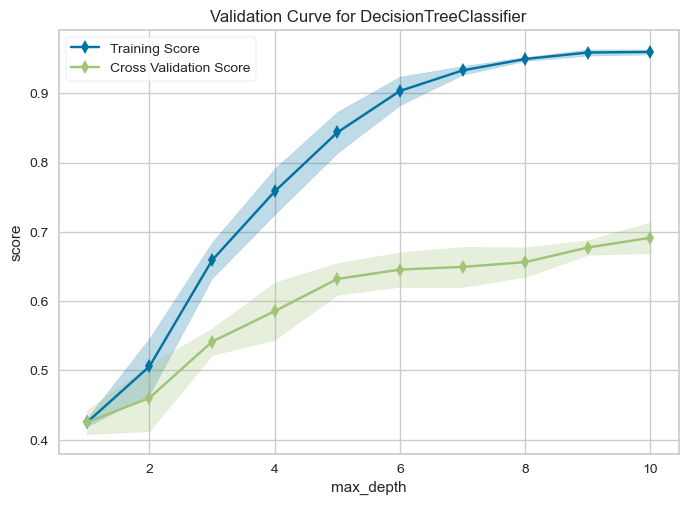

<Axes: title={'center': 'Validation Curve for DecisionTreeClassifier'}, xlabel='max_depth', ylabel='score'>

In [378]:
viz = ValidationCurve(
    DecisionTreeClassifier(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=cv, scoring=f1_weighted
)
viz.fit(X_train, y_train)
viz.show()

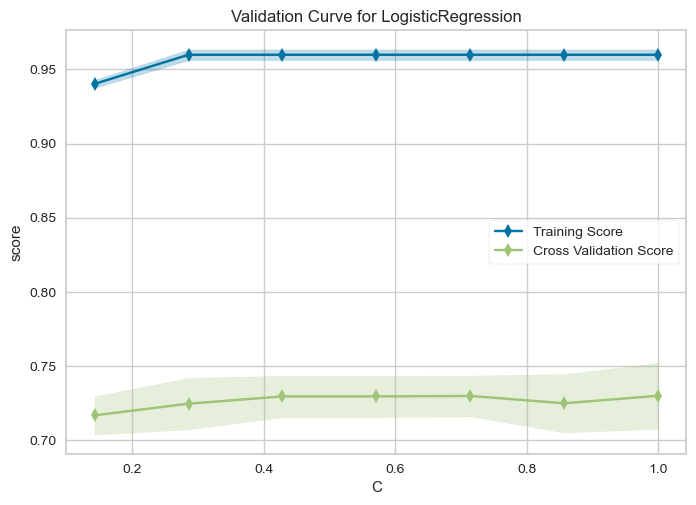

<Axes: title={'center': 'Validation Curve for LogisticRegression'}, xlabel='C', ylabel='score'>

In [379]:
viz = ValidationCurve(
    LogisticRegression(penalty='l2'), param_name="C",
    param_range=np.linspace(0, 1, 8), cv=cv, scoring=f1_weighted
)
viz.fit(X_train, y_train)
viz.show()